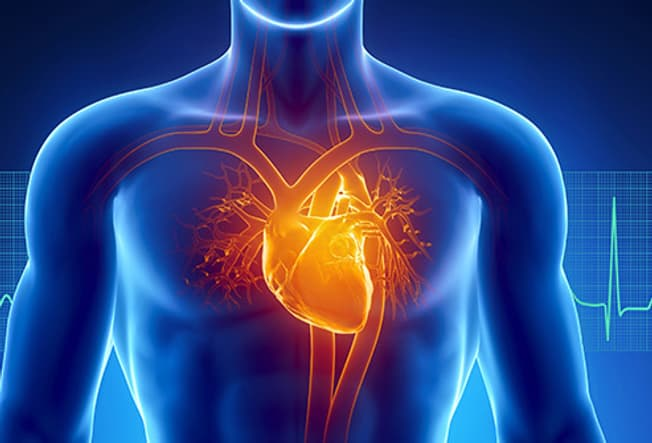

# HW15 - Classification Analysis - Predicting chance of Heart Disease

## Table of contents

- [Step 1](#step_1): Import libraries
- [Step 2](#step_2): Read dataset
- [Step 3](#step_3): Prepare features
- [Step 4](#step_4): Build model
- [Step 5](#step_5): Optimize model with regularization 

## this kind of sucks... either try new data set, or use new features (not the standardized ones)

<a id=’step_1’></a>
## Step 1: Import libraries

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

<a id=’step_2’></a>
## Step 2: Read dataset

In [2]:
# https://www.kaggle.com/datasets/dileep070/heart-disease-prediction-using-logistic-regression?resource=download
DATA_PATH = Path.cwd().parent.joinpath('data')
filename = Path.joinpath(DATA_PATH, 'heart_disease_data.csv')
print(filename)
df = pd.read_csv(filename)
df.head()

/home/studio-lab-user/intuit-ga-dat17/projects/ds-classification-metrics-hw15/data/heart_disease_data.csv


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
#917 rows
df.shape

(4238, 16)

In [4]:
# ~16% chance of heart disease
df['TenYearCHD'].value_counts()

0    3594
1     644
Name: TenYearCHD, dtype: int64

In [5]:
# rename column I want to predict
df.rename(columns = {'TenYearCHD':'y'}, inplace = True)
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,y
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [6]:
# check for missing data
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
y                    0
dtype: int64

In [7]:
# not using glucose, so drop and then delete all other nulls
df.drop('glucose',axis=1)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,y
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,0


In [8]:
# remove missing data & reset the index
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.shape

(3656, 16)

<a id=’step_3’></a>
## Step 3: Prepare features

In [10]:
# standardize age, education, totChol, and BMI 

# standardization

ss_scaler1 = StandardScaler()
ss_scaler2 = StandardScaler()
ss_scaler3 = StandardScaler()
ss_scaler4 = StandardScaler()
ss_scaler5 = StandardScaler()


ln_age  = np.log(df['age']).values
df['ln_age'] = ss_scaler1.fit_transform(np.array(ln_age).reshape(-1, 1))

ln_education  = np.log(df['education']).values
df['ln_education'] = ss_scaler2.fit_transform(np.array(ln_education).reshape(-1, 1))

ln_totChol  = np.log(df['totChol']).values
df['ln_totChol'] = ss_scaler4.fit_transform(np.array(ln_totChol).reshape(-1, 1))

ln_BMI  = np.log(df['BMI']).values
df['ln_BMI'] = ss_scaler5.fit_transform(np.array(ln_BMI).reshape(-1, 1))

In [11]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,y,ln_age,ln_education,ln_totChol,ln_BMI
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,-1.296460,1.627578,-0.962849,0.372820
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,-0.343635,0.276594,0.384651,0.788095
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,-0.097985,-1.074390,0.275084,-0.036702
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,1.285384,1.066869,-0.186759,0.753708
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,-0.343635,1.066869,1.095267,-0.644679


In [12]:
# create new dataframe with variables I want to use
features = ['male','ln_age','ln_education','ln_totChol','ln_BMI','currentSmoker','y']
model = df[features]
model.head()

,male,ln_age,ln_education,ln_totChol,ln_BMI,currentSmoker,y
0,1,-1.296460,1.627578,-0.962849,0.372820,0,0
1,0,-0.343635,0.276594,0.384651,0.788095,0,0
2,1,-0.097985,-1.074390,0.275084,-0.036702,1,0
3,0,1.285384,1.066869,-0.186759,0.753708,1,1
4,0,-0.343635,1.066869,1.095267,-0.644679,1,0


<a id=’step_4’></a>
## Step 4: Build model

In [13]:
# set x and y
y = model['y']
print(y.shape)

X = model.drop('y', axis=1)
print(X.shape)


(3656,)
(3656, 6)


In [14]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# fit model
logreg = LogisticRegression(max_iter=200) 
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [15]:
#what are the coefficients?
feature_cols = X.columns
coeffs=pd.DataFrame(list(zip(feature_cols, logreg.coef_[0])), columns=['feature','coef'])
coeffs.set_index('feature', inplace=True)
coeffs.sort_values('coef', ascending=False).head(15)

,coef
feature,
ln_age,0.738170
male,0.580654
currentSmoker,0.364162
ln_totChol,0.144523
ln_BMI,0.134487
ln_education,-0.073432


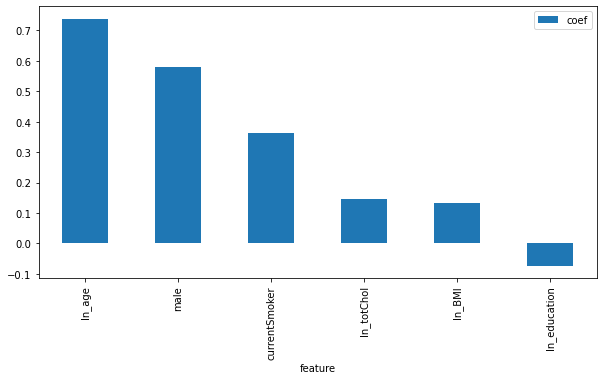

In [16]:
# display the coefficients as a bar chart
coeffs.sort_values('coef', ascending=False).plot(kind='bar', figsize=(10,5));

Insights:
- Age and gener are largest indicators of heart disease


In [17]:
# predict on the testing dataset
y_preds=logreg.predict(X_test)
print('preds', list(y_preds[:10]))
print('truth', list(y_test[:10]))

preds [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
truth [0, 0, 0, 0, 1, 1, 0, 0, 0, 0]


In [18]:
# The model is not very accurate... 
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, log_loss
print(accuracy_score(y_preds, y_test))

0.8424507658643327


In [19]:
## 162 true negatives, 6 true positives, and 57 false negatives and 5 false positives... it's predicting being alive vast majority of the time
print(f'Accuracy: {accuracy_score(y_test,y_preds)}')
print()
print(f'Confusion Matrix:\n {confusion_matrix(y_test,y_preds)}')
print()
print(f'ROC-AUC Score: {roc_auc_score(y_test,y_preds)}')
print()
print(f'Log Loss: {log_loss(y_test,y_preds)}')


Accuracy: 0.8424507658643327

Confusion Matrix:
 [[770   2]
 [142   0]]

ROC-AUC Score: 0.49870466321243523

Log Loss: 5.441559518667394


In [20]:
# compare to baseline
baseline_preds = np.empty(len(y_test))
baseline_preds.fill(False)
print(accuracy_score(baseline_preds, y_test))

0.8446389496717724


In [ ]:
# the model is similar/slightly worse than the baseline.

<a id=’step_5’></a>
## Step 5: Optimize model with regularization 

In [21]:
# X and y features
y2 = model['y']
X2 = model.drop('y', axis=1)

In [24]:
# using train test split to cross val
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2,y2, random_state =42)

cees = [0.01, 0.1, 1.0, 10, 100]

print('ROC : C')
for c in cees:
    logreg2 = LogisticRegression(penalty='l2', C=c, max_iter=2500) # set max_iter to avoid warning
    logreg2.fit(x_train2,y_train2)
    y_pred2 = logreg.predict(x_test2)
    roc = metrics.roc_auc_score(y_test2, y_pred2)
    print(roc," : ", c)

ROC : C
0.49870466321243523  :  0.01
0.49870466321243523  :  0.1
0.49870466321243523  :  1.0
0.49870466321243523  :  10
0.49870466321243523  :  100


In [29]:
#compare accuracies 
print(accuracy_score(y_test, y_preds))
print(accuracy_score(y_test2, y_pred2))

0.8424507658643327
0.8424507658643327


In [ ]:
# Regularization doesn't seem to make a difference...